# Waste Classifier
In this project, I am going to try and predict whether the content of a photo is a recyclable or organic material. The dataset used in this project is obtained from Kaggle: https://www.kaggle.com/techsash/waste-classification-data

- Goal: Predict whether the object in an image is recyclable or organic
- Input feature(s): Images
- Target: Category (organic/recyclable) for the image

## Data Overview

### Importing libraries and reading the dataset

In [1]:
import matplotlib.pyplot as plt
import cv2
import fnmatch
import os
import time
import numpy as np

from sklearn.neighbors import KNeighborsClassifier

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Activation

Using TensorFlow backend.


In [2]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
label_texts = ['Organic', 'Recyclable']

As there are a lot of images in the training dataset which can increase the training time for my models, I decided to only load the first 4000 images from each category

In [3]:
def load_img_from_folder(folderPath, label, maxcount):
    images = []
    labels = []
    cnt = 0 
    for file in os.listdir(folderPath):
        if cnt == maxcount:
            break
        img_path = os.path.join(folderPath, file)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
        images.append(image)
        labels.append(label)
        cnt += 1
    return images, labels
    
def load_dataset():
    datasets = ['DATASET/TRAIN', 'DATASET/TEST']
    output = []
    for dataset in datasets:
        images = []
        labels = []
        imgs_o, labels_o = load_img_from_folder(os.path.join(dataset, 'O'), 0, 4000)
        imgs_r, labels_r = load_img_from_folder(os.path.join(dataset, 'R'), 1, 4000)
        images.extend(imgs_o)
        images.extend(imgs_r)
        labels.extend(labels_o)
        labels.extend(labels_r)
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')
        output.append((images, labels))
    return output        

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_dataset()

### Dataset Exploratory Analysis

In [5]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]
print('Number of training images: ', n_train)
print('Number of testing images: ', n_test)

Number of training images:  8000
Number of testing images:  2513


In [6]:
def print_label_counts(labels):
    names, counts = np.unique(labels, return_counts=True)
    for i in range(names.size):
        print(label_texts[names[i]], ": ", counts[i])

In [7]:
print("Training dataset content:")
print_label_counts(train_labels)

Training dataset content:
Organic :  4000
Recyclable :  4000


In [8]:
print("Testing dataset content:")
print_label_counts(test_labels)

Testing dataset content:
Organic :  1401
Recyclable :  1112


Displaying random sample image from the dataset

In [9]:
def display_sample_images(images, labels, label_texts):
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Dataset examples", fontsize=18)
    for i in range(25):
        index = np.random.randint(images.shape[0])
        plt.subplot(5, 5, i+1)
        plt.imshow(images[index].astype('uint8'))
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.xlabel(label_texts[labels[index ]])
    plt.show

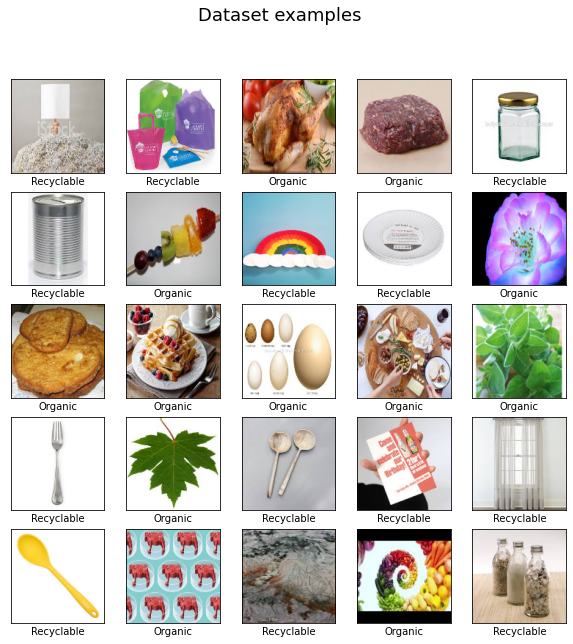

In [10]:
display_sample_images(train_images, train_labels, label_texts)

## Training and Validation

In this project, I will try to use 3 different methods for my training and prediction, and compare their effectiveness. These 3 models are K-Nearest Neighbors, Multi-layer Perceptron and Convolutional Neural Network

First, I normalize the image values from 0-255 (integer) to 0-1 (float)

In [11]:
train_images = train_images / 255.0
test_images = test_images / 255.0

### K-Nearest Neighbor

Create input features for KNN by flattening the image into an array of size 49152 (128*128*3)

In [12]:
def img_to_vec(image):
    return image.flatten()

In [13]:
def images_to_feature_vectors(images):
    features = []
    for image in images:
        features.append(img_to_vec(image))
    return np.array(features)

In [14]:
X_train = images_to_feature_vectors(train_images)
y_train = train_labels
X_test = images_to_feature_vectors(test_images)
y_test = test_labels
X_train[0].shape

(49152,)

To figure out the optimal number of neighbors for the model, I train the model multiple times with number of neighbors ranging from 5 to 100, and compare the accuracy

In [15]:
num_neighbors = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
accuracy = []
start = time.time()
print('Started training KNN')
for n_neighbor in num_neighbors:
    print('Training with number of neighbors = ', n_neighbor)
    model = KNeighborsClassifier(n_neighbors = n_neighbor, n_jobs = -1)
    model.fit(X_train, y_train)
    acc = model.score(X_test, y_test)
    print('accuracy: {0:.2f}%'.format(acc*100))
    accuracy.append(acc*100)
print(time.strftime("Execution time: %H:%M:%S", time.gmtime(time.time() - start)))

Started training KNN
Training with number of neighbors =  5
accuracy: 66.14%
Training with number of neighbors =  10
accuracy: 74.77%
Training with number of neighbors =  20
accuracy: 77.40%
Training with number of neighbors =  30
accuracy: 77.68%
Training with number of neighbors =  40
accuracy: 78.59%
Training with number of neighbors =  50
accuracy: 79.19%
Training with number of neighbors =  60
accuracy: 79.35%
Training with number of neighbors =  70
accuracy: 79.71%
Training with number of neighbors =  80
accuracy: 80.02%
Training with number of neighbors =  90
accuracy: 79.98%
Training with number of neighbors =  100
accuracy: 80.02%
Execution time: 01:45:44


<function matplotlib.pyplot.show(*args, **kw)>

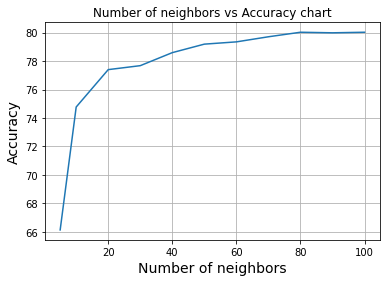

In [16]:
plt.plot(num_neighbors, accuracy)
plt.xlabel('Number of neighbors', size=14)
plt.ylabel('Accuracy', size=14)
plt.title('Number of neighbors vs Accuracy chart')
plt.grid()
plt.show

From the result and graph, we can see that the optimal number of neighbors out of all tested values is 80 or 100, with the accuracy of 80.02%

### Multi-layer Perceptron

Define the batch_size and number of epochs for the model

In [17]:
batch_size = 32
epochs = 20

Preparing the target value for the MLP model with one hot encoding. We can use the same feature vectors from KNN as the input vectors, hence no change is needed for X_train and X_test

In [18]:
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)
y_train[0]

array([1., 0.], dtype=float32)

Define the MLP model with 2 Dense layer, each is followed by a Dropout with rate of 0.2

In [19]:
mlp_model = Sequential()
mlp_model.add(Dense(512, activation='relu', input_shape=(49152,)))
mlp_model.add(Dropout(0.2))
mlp_model.add(Dense(512, activation='relu'))
mlp_model.add(Dropout(0.2))
mlp_model.add(Dense(2, activation='softmax'))
mlp_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               25166336  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1026      
Total params: 25,430,018
Trainable params: 25,430,018
Non-trainable params: 0
_________________________________________________________________


Compiling, training and validating the model

In [20]:
mlp_model.compile(loss='categorical_crossentropy',
                 optimizer='rmsprop',
                 metrics=['accuracy'])
start = time.time()
history = mlp_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test))
score = mlp_model.evaluate(X_test, y_test, verbose=0)
print('Test loss: ', score[0])
print('Test accuracy', score[1])
print(time.strftime("Execution time: %H:%M:%S", time.gmtime(time.time() - start)))

Train on 8000 samples, validate on 2513 samples
Epoch 1/20
8000/8000 [==============================] - 89s 11ms/step - loss: 8.0495 - accuracy: 0.5104 - val_loss: 0.6914 - val_accuracy: 0.5575
Epoch 2/20
8000/8000 [==============================] - 83s 10ms/step - loss: 0.8554 - accuracy: 0.4964 - val_loss: 0.6920 - val_accuracy: 0.5583
Epoch 3/20
8000/8000 [==============================] - 80s 10ms/step - loss: 0.8246 - accuracy: 0.5049 - val_loss: 0.6932 - val_accuracy: 0.4433
Epoch 4/20
8000/8000 [==============================] - 81s 10ms/step - loss: 0.7527 - accuracy: 0.4980 - val_loss: 0.6934 - val_accuracy: 0.4429
Epoch 5/20
8000/8000 [==============================] - 80s 10ms/step - loss: 0.7066 - accuracy: 0.5092 - val_loss: 0.6899 - val_accuracy: 0.5583
Epoch 6/20
8000/8000 [==============================] - 81s 10ms/step - loss: 0.6987 - accuracy: 0.5001 - val_loss: 0.6902 - val_accuracy: 0.5591
Epoch 7/20
8000/8000 [==============================] - 80s 10ms/step - loss

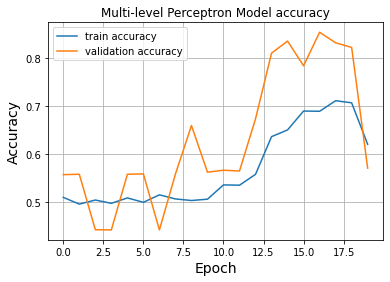

In [21]:
plt.plot(history.history["accuracy"], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch', size=14)
plt.ylabel('Accuracy', size=14)
plt.title('Multi-level Perceptron Model accuracy')
plt.legend()
plt.grid()
plt.show()

From the result and graph, we can see that the model has a peak test accuracy of 85.28% at epoch 17, but has a drastic drop in accuracy in the last epoch down to 57.10%.

### Convolutional Neural Network

Redefine the input features as the image itself, define number of epochs for the model as 10 instead of 20 as above.

In [27]:
epochs=10

X_train = train_images
X_test = test_images

Define the CNN model

In [28]:
cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Conv2D(32, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(2, activation='softmax'))
cnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 28800)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)              

Compile, train and validate the model

In [29]:
cnn_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
start = time.time()
history = cnn_model.fit(X_train, y_train, 
                        batch_size=batch_size, 
                        epochs=epochs, 
                        validation_data=(X_test, y_test))
score = cnn_model.evaluate(X_test, y_test, verbose=0)
print('Test loss: ', score[0])
print('Test accuracy', score[1])
print(time.strftime("Execution time: %H:%M:%S", time.gmtime(time.time() - start)))

Train on 8000 samples, validate on 2513 samples
Epoch 1/10
8000/8000 [==============================] - 85s 11ms/step - loss: 0.8016 - accuracy: 0.7460 - val_loss: 0.3756 - val_accuracy: 0.8663
Epoch 2/10
8000/8000 [==============================] - 85s 11ms/step - loss: 0.4449 - accuracy: 0.8020 - val_loss: 0.3409 - val_accuracy: 0.8735
Epoch 3/10
8000/8000 [==============================] - 87s 11ms/step - loss: 0.4116 - accuracy: 0.8184 - val_loss: 0.3172 - val_accuracy: 0.8814
Epoch 4/10
8000/8000 [==============================] - 86s 11ms/step - loss: 0.3914 - accuracy: 0.8275 - val_loss: 0.3208 - val_accuracy: 0.8818
Epoch 5/10
8000/8000 [==============================] - 86s 11ms/step - loss: 0.3626 - accuracy: 0.8439 - val_loss: 0.3923 - val_accuracy: 0.8500
Epoch 6/10
8000/8000 [==============================] - 91s 11ms/step - loss: 0.3391 - accuracy: 0.8580 - val_loss: 0.3025 - val_accuracy: 0.8910
Epoch 7/10
8000/8000 [==============================] - 101s 13ms/step - los

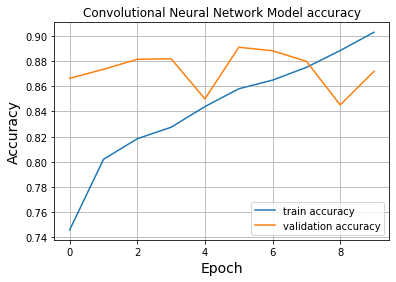

In [31]:
plt.plot(history.history["accuracy"], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch', size=14)
plt.ylabel('Accuracy', size=14)
plt.title('Convolutional Neural Network Model accuracy')
plt.legend()
plt.grid()
plt.show()

From the training/validation result, we can see that the model has a peak performance of 89.10% at epoch 6. Overall, the model has a pretty consistently high accuracy at around 86% (best performance out of all 3); however, the reduction in the validation accuracy at the end together with the consistently rising trend of the training accuracy might suggest an overfitting problem.

## Conclusion and Insights

- CNN has the best performance out of the 3 models, which is something I expected before starting the project
- On the other hand, I did not expect KNN model to have performed that well (at roughly 80% accuracy), which is pretty interesting in my opinion. I would have expected the result to be at about 60-65% accuracy.
- Changing the color to grayscale, interestingly, reduces the performance of the models.
- Changing other hyper-variables 